In [580]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.multioutput import MultiOutputRegressor

from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.model_selection import cross_val_score, GridSearchCV, TimeSeriesSplit


from sklearn.impute import SimpleImputer

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, explained_variance_score
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import make_scorer

from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator

from prophet import Prophet


import datetime

from sklearn import set_config
set_config(display='diagram') 

plt.rcParams['figure.figsize'] = [20, 20]

sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')


sns.set(rc={'figure.figsize':(20, 10)})
sns.set_context("poster")
sns.set_style("white")
palette = sns.color_palette("mako_r", 6)

Importing plotly failed. Interactive plots will not work.


# Helper functions

In [17]:
def import_data():
    # charging session data 
    
    df1 = pd.read_csv('Fort Collins Utilities EV Data June 2020 to June 2021.csv')
    
    df2 = pd.read_csv('Fort Collins Utilities EV Data June 25 2021 to July 20 2021.csv')
    
  
    return pd.concat([df1, df2])

In [18]:
df = import_data()

In [302]:
df = (df.rename(columns={'Session/Reservation Start Date': 'Date'})
        .assign(date=lambda x: pd.to_datetime(x['Date']))
        .dropna(how='all')
        .set_index('date')
       
     )

# Do some cleaning

In [303]:
df2 = (df[['Energy (kWh)', 'Net Revenue']]
       .resample('1D')
       .sum()
)

In [304]:
df2.isna().sum()

Energy (kWh)    0
Net Revenue     0
dtype: int64

In [305]:
df2["Net Revenue_7D"] = df2['Net Revenue'].\
                         transform(lambda x: x.rolling(7, min_periods=7, closed='both', center=True).median())

df2['Net Revenue_7D'] = df2['Net Revenue_7D'].interpolate(method='linear', limit_direction='both')

# We can see that revenue is steadily increasing as COVID restrictions are easing in mid 2021

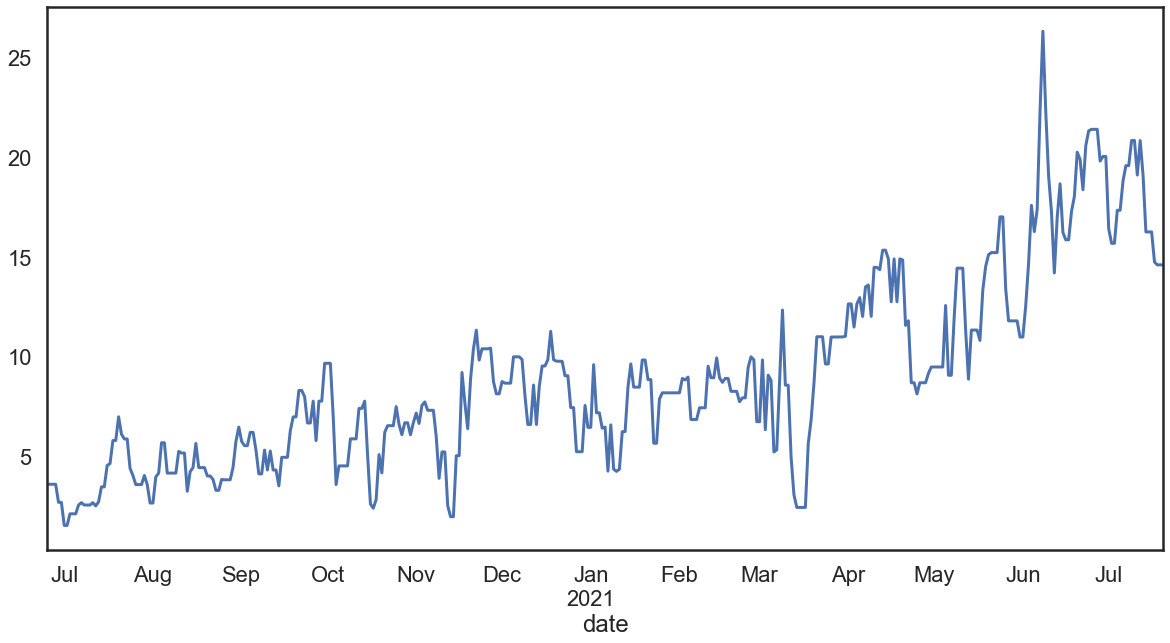

In [306]:
df2['Net Revenue_7D'].plot()

# Lets compare some different forecasting approaches and compare the performance with walk-forward validation

In [39]:
import sys
sys.path.append('app3/EV_forecasting/ml/')

In [49]:
from transformers import FourierTransformer, RollingMeanTransformer, TrendTransformer, DayofWeek, MonthofYear

# SKlearn pipeline to implement and XGBoost regressor

# We have to fit the differenced time series because the time series is non-stationary (not constant mean and variance over time)

- Time series is not stationary according to ADF test
- Then we will perform an inverse difference transform to compare the predictions with the actual test data

In [416]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df2['Net Revenue_7D'].ffill(0))
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -1.383381
p-value: 0.590217
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of Series.ffill will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [456]:
from sklearn.linear_model import LinearRegression

X = np.array(range(len(np.log(df2['Net Revenue_7D']))))
y = np.log(df2['Net Revenue_7D']).ffill(axis=0)

In [457]:
# Linear Trend
reg = LinearRegression().fit(X.reshape(-1,1), y)
pred_lin = reg.predict(X.reshape(-1,1))  

In [419]:
df2['Net Revenue_7D_diff'] = df2['Net Revenue_7D'] - pred_lin

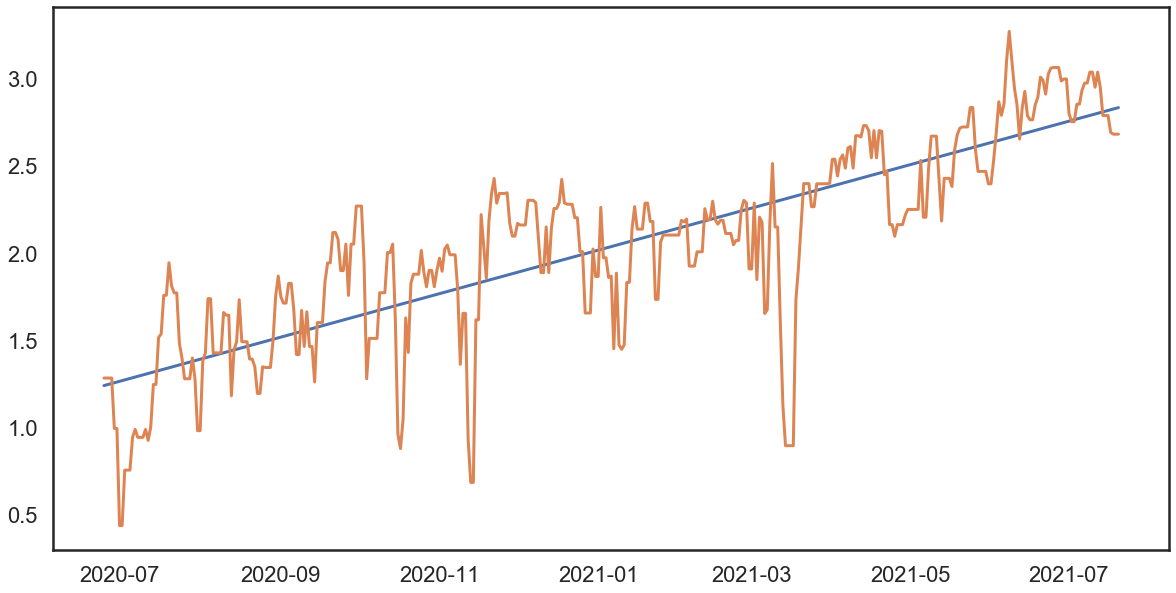

In [458]:
#df2['Net Revenue_7D'].plot()
plt.plot(df2['Net Revenue_7D'].index, pred_lin, label="linear trend")
plt.plot(np.log(df2['Net Revenue_7D']))

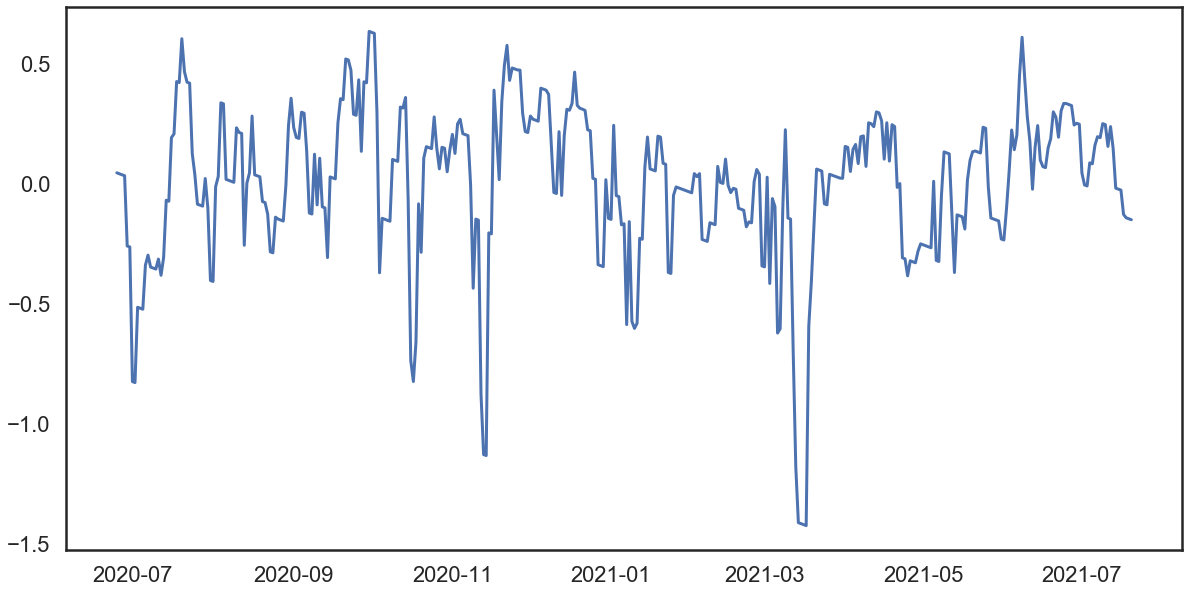

In [868]:
plt.plot(np.log(df2['Net Revenue_7D']) - pred_lin)

In [869]:
df2['revenue_trans'] = np.log(df2['Net Revenue_7D']) - pred_lin

In [984]:
lags = np.arange(-30, 0, 1)
for lag in lags:
    df2['lag_'+ 'revenue' + str(lag)] = \
                df2['revenue_trans'].shift(lag)
df2_ = df2.dropna(how='any')

In [985]:
X_train, X_test = df2_[:"2021-05-01"], df2_["2021-05-01":]

In [986]:
y_train = X_train.loc[:, X_train.columns.str.startswith('lag')]
y_test = X_test.loc[:, X_test.columns.str.startswith('lag')]

In [1003]:
fourier_feautres = ColumnTransformer(
    transformers=[
        ('fourier-w', FourierTransformer(period=7), ['revenue_trans']),
        ('fourier-1m', FourierTransformer(period=30), ['revenue_trans']),
        ('fourier-3m', FourierTransformer(period=3*30), ['revenue_trans']),
        ('fourier-6m', FourierTransformer(period=6*30), ['revenue_trans']),
        ('fourier-y', FourierTransformer(period=365), ['revenue_trans'])
    ]
)

rolling_mean_trans = ColumnTransformer(
    transformers=[
       ('rolling-mean', RollingMeanTransformer(window=60), ['revenue_trans'])
    ]
)

trend_trans = ColumnTransformer(
    transformers=[
       ('trend', TrendTransformer(), ['revenue_trans'])
    ]
)

union = FeatureUnion([('fourier-components', fourier_feautres),
                      ('rolling_mean', rolling_mean_trans),
                      ('trend', trend_trans),
                      ('day_of_week', DayofWeek()),
                      ('month_of_year', MonthofYear())
                      ])

pipe = Pipeline([('union', union),
                 ('lr', MultiOutputRegressor(XGBRegressor()))])


In [1004]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('fourier-components',
                                                 ColumnTransformer(transformers=[('fourier-w',
                                                                                  FourierTransformer(period=7),
                                                                                  ['revenue_trans']),
                                                                                 ('fourier-1m',
                                                                                  FourierTransformer(period=30),
                                                                                  ['revenue_trans']),
                                                                                 ('fourier-3m',
                                                                                  FourierTransformer(period=90),
                                                                                  ['revenue_trans']),
                                                                                 ('fourier-6m',
                                                                                  FourierTransformer(period=180),
                                                                                  ['revenu...
                                                             importance_type='gain',
                                                             interaction_constraints=None,
                                                             learning_rate=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             n_estimators=100,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=None,
                                                             reg_alpha=None,
                                                             reg_lambda=None,
                                                             scale_pos_weight=None,
                                                             subsample=None,
                                                             tree_method=None,
                                                             validate_parameters=None,
                                                             verbosity=None)))])

In [1005]:
predictions = pd.DataFrame(pipe.predict(X_test)[:, -1], index=X_test.index, columns=['revenue_trans'])
predictions['Group'] = 'predictions'

In [1006]:
X_test['Group'] = 'Test'
X_train['Group'] = 'Train'

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [1007]:
merged = pd.concat([X_train, X_test, predictions])

In [1008]:
X_full = np.array(range(0, len(df2)))
pred_lin = reg.predict(X_full.reshape(-1,1)) 

In [1009]:
series = merged.loc[merged.Group=="predictions", 'revenue_trans']

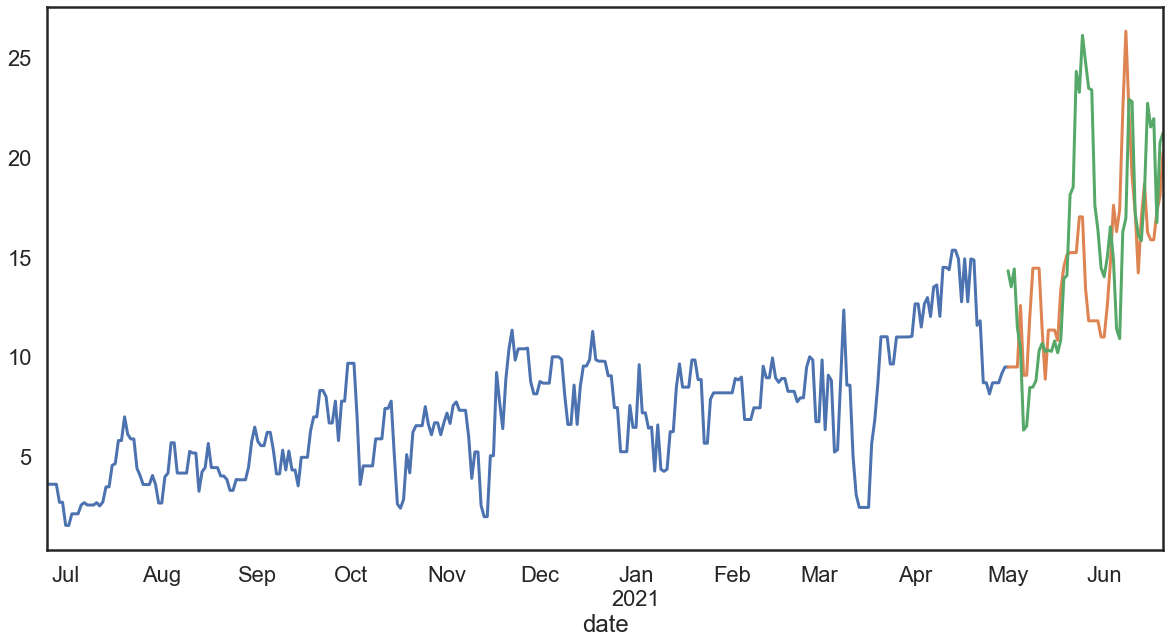

In [1010]:
merged.loc[merged.Group=="Train", 'Net Revenue_7D'].plot()
merged.loc[merged.Group=="Test", 'Net Revenue_7D'].plot()
np.exp(series + pred_lin[-len(series):]).plot()

## scaled predictions by applying inverse log transform to prediction with added linear trend

In [1011]:
test = merged.loc[merged.Group=="Test", 'Net Revenue_7D']
predictions = np.exp(series + pred_lin[-len(series):])

In [1012]:

mape = mean_absolute_percentage_error(predictions, test)
f'The MAPE for the test period is {mape*100:.2f}%'

'The MAPE for the test period is 25.26%'

# 17 % MAPE for the test set using XGBoost on differenced and log-transformed data and using fourier-components
We could possibly perform time series cross-validation to improve the generalization error on the test set.

# Lets try modeling with FBProphet

In [915]:
train = df2.loc[:'2021-06-10', 'Net Revenue_7D'].reset_index()
test = df2.loc['2021-06-10':, 'Net Revenue_7D'].reset_index()

In [916]:
train = train.rename(columns={'date':'ds',
                      'Net Revenue_7D': 'y'})

In [917]:

def is_stay_at_home(ds):
    date = pd.to_datetime(ds)
    return (date >= pd.Timestamp(2020,3,25) and date < pd.Timestamp(2020,4,26))


def create_end_of_year_holidays_df():
    """Create holidays data frame for the end of the year season."""
    holidays = pd.DataFrame({
      'holiday': 'end_of_year',
      'ds': pd.to_datetime(
          ['2019-12-25', '2020-12-25']
      ),
      'lower_window': -7,
      'upper_window': 7,
    })
    return holidays


def build_model():
    """Define forecasting model."""
    # Create holidays data frame. 
    holidays = create_end_of_year_holidays_df()
    
    model = Prophet(
        #yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False, 
        holidays = holidays, 
        interval_width=0.95, 
    )

    model.add_seasonality(
        name='monthly', 
        period=30.5, 
        fourier_order=20
    )

#     model.add_seasonality(
#         name='stay_at_home', 
#         period=7, 
#         fourier_order=5, 
#         condition_name='is_stay_at_home'
#     )
#     model.add_seasonality(
#         name='no_stay_at_home', 
#         period=7, 
#         fourier_order=5, 
#         condition_name='is_not_stay_at_home')
    
    return model
    

In [918]:
model = Prophet()
model = build_model()

In [919]:
# train['is_stay_at_home'] = train['ds'].apply(is_stay_at_home)
# train['is_not_stay_at_home'] = ~train['ds'].apply(is_stay_at_home)

In [920]:
model.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


# generate predictions

In [921]:
# Extend dates and features. 
future = model.make_future_dataframe(periods=test.shape[0])
# future['is_stay_at_home'] = future['ds'].apply(is_stay_at_home)
# future['is_not_stay_at_home'] = ~future['ds'].apply(is_stay_at_home)
# Generate predictions. 
forecast = model.predict(df=future)

In [922]:

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
387,2021-07-17,16.520558,12.061332,20.364888
388,2021-07-18,16.461301,12.400904,20.332201
389,2021-07-19,17.610590,13.146989,22.124798
390,2021-07-20,18.407466,14.477162,22.156029
391,2021-07-21,18.382170,14.285752,22.296679


In [923]:
mask2 = forecast['ds'] <= "2021-06-10"

forecast_train = forecast[mask2]
forecast_test = forecast[~ mask2]

In [924]:
from prophet.plot import add_changepoints_to_plot

[[<matplotlib.lines.Line2D at 0x7fac89267e10>],

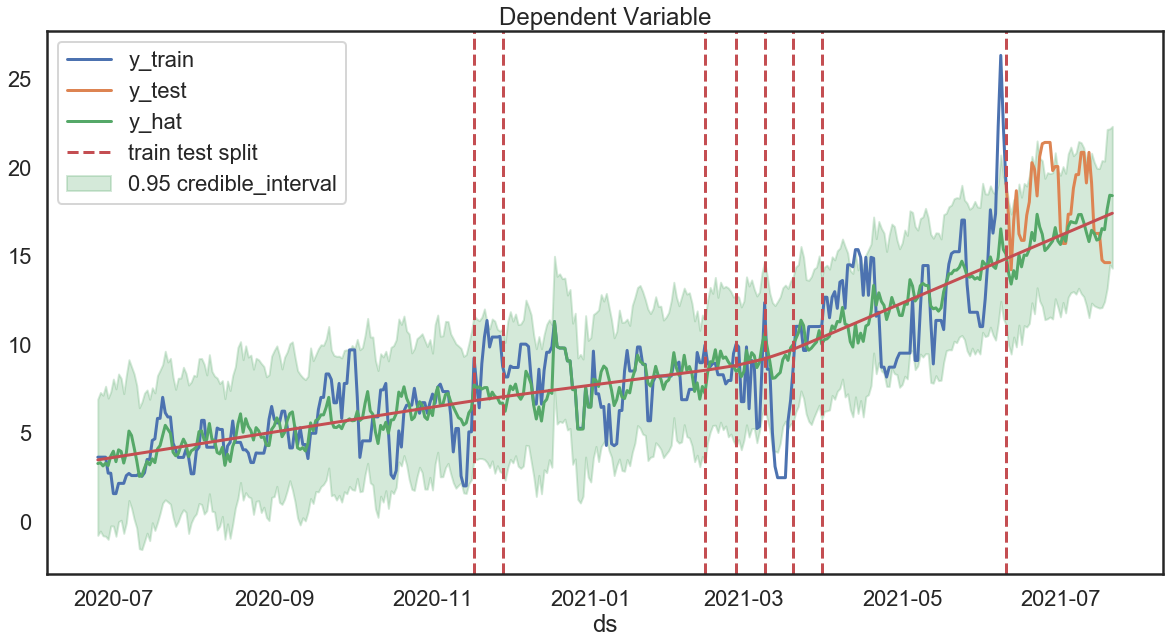

In [925]:
fig, ax = plt.subplots()

ax.fill_between(
    x=forecast['ds'],
    y1=forecast['yhat_lower'],
    y2=forecast['yhat_upper'],
    color=sns_c[2], 
    alpha=0.25,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='y', label='y_train', data=train, ax=ax)
sns.lineplot(x='date', y='Net Revenue_7D', label='y_test', data=test, ax=ax)
sns.lineplot(x='ds', y='yhat', label='y_hat', data=forecast, ax=ax)
ax.axvline(datetime.datetime(2021,6,10), color=sns_c[3], linestyle='--', label='train test split')
ax.legend(loc='upper left')
ax.set(title='Dependent Variable', ylabel='');

    
add_changepoints_to_plot(ax, model, forecast)

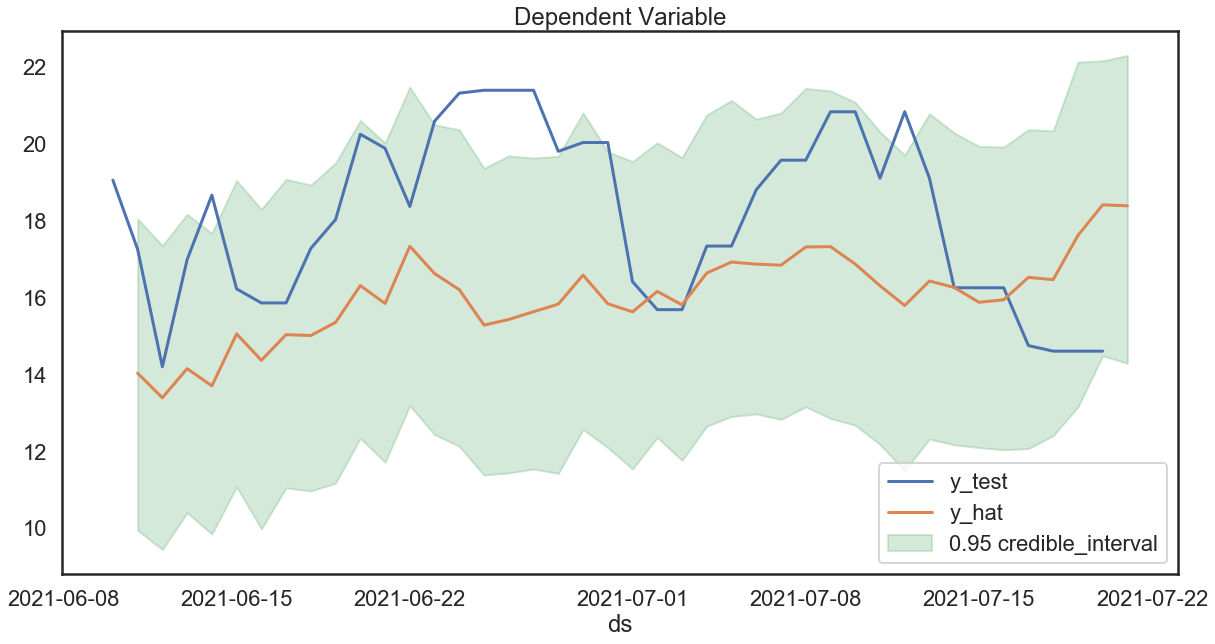

In [926]:
fig, ax = plt.subplots()

ax.fill_between(
    x=forecast_test['ds'],
    y1=forecast_test['yhat_lower'],
    y2=forecast_test['yhat_upper'],
    color=sns_c[2], 
    alpha=0.25,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='date', y='Net Revenue_7D', label='y_test', data=test, ax=ax)
sns.lineplot(x='ds', y='yhat', label='y_hat', data=forecast_test, ax=ax)
ax.legend(loc='lower right')
ax.set(title='Dependent Variable', ylabel='');

In [927]:
from sklearn.metrics import r2_score, mean_absolute_error

print('r2 train: {}'.format(r2_score(y_true=train['y'], y_pred=forecast_train['yhat'])))
print('r2 test: {}'.format(r2_score(y_true=test['Net Revenue_7D'], y_pred=forecast_test['yhat'])))
print('---'*10)
print('mape train: {}'.format(mean_absolute_percentage_error(y_true=train['y'], y_pred=forecast_train['yhat'])))
print('mape test: {}'.format(mean_absolute_percentage_error(y_true=test['Net Revenue_7D'], y_pred=forecast_test['yhat'])))

r2 train: 0.6964785623014056
r2 test: -1.1591347848435327
------------------------------
mape train: 0.25596070819701827
mape test: 0.14526551047371986


# As an MVP, Lets go with FBprophet in our web app because it achieves a slightly better overall MAPE than an untuned XGBoost

# TO DO:
## implement SARIMAX

## implement walk-forward validation to evaluate the 1-month and 3-month MAPE and compare all methods